In [1]:
import tdt
import numpy as np  # fundamental package for scientific computing, handles arrays and maths
import pandas as pd
from matplotlib.pyplot import figure
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.size'] = 18 # set font size for all figures
from tdt import read_block, StructType
import scipy.stats as stats
from statistics import mean
np.set_printoptions(precision=4)
import statistics
import os

In [2]:
import os
print("Current Working Directory:", os.getcwd())

Current Working Directory: C:\Users\sabri\Documents\FiberPhotometry_DATA


In [3]:
Session_name = 'Data'
tailfile_name = 'C9_O'

In [4]:
fiberphotometry_path = os.path.join(r"C:\Users\sabri\Dropbox\PC\Documents\FiberPhotometry_DATA", Session_name, tailfile_name)
print(fiberphotometry_path)

C:\Users\sabri\Dropbox\PC\Documents\FiberPhotometry_DATA\Data\C9_O


In [5]:
GCAMP = '_470A' # GCaMP channel
ISOS = '_405A' # Isosbestic channel
N = 34 # Average every X samples into 1 value
# determine the number of seconds you want to remove from the beginning of the trace to remove artifacts 
t_removal = 5
# determine the number of seconds you want to remove from the end of the trace to remove artifacts 
t_end_removal = 5

In [6]:

my_dict = {}
time_point_dict = {}
syn_time_vector = []
F405 = []
F470 = []
STIM_SYNC = 'Ep1_'
data = read_block(fiberphotometry_path)
pc0_on = data.epocs[STIM_SYNC].onset
F470 = data.streams[GCAMP].data
F405 = data.streams[ISOS].data
num_samples = len(data.streams[GCAMP].data)
total_time =  num_samples / data.streams[GCAMP].fs
# where I remove end fiberphotometry 
time = np.linspace(1,len(data.streams[GCAMP].data), len(data.streams[GCAMP].data))/data.streams[GCAMP].fs
my_dict[tailfile_name] = {"405": F405, "470": F470, "Time":time}
time_point_dict[tailfile_name] = {"ep1":pc0_on}
syn_time_vector.append(pc0_on[0])
print( str(tailfile_name) + " contains Ep1_ pulse at : " + str(pc0_on))
print(data.streams[GCAMP].fs)
print("length of the data" +  str(len(data.streams[GCAMP].data)))
frequency = data.streams[GCAMP].fs

Found Synapse note file: C:\Users\sabri\Dropbox\PC\Documents\FiberPhotometry_DATA\Data\C9_O\Notes.txt
read from t=0s to t=526.23s
C9_O contains Ep1_ pulse at : [147.1295]
1017.2526245117188
length of the data535296


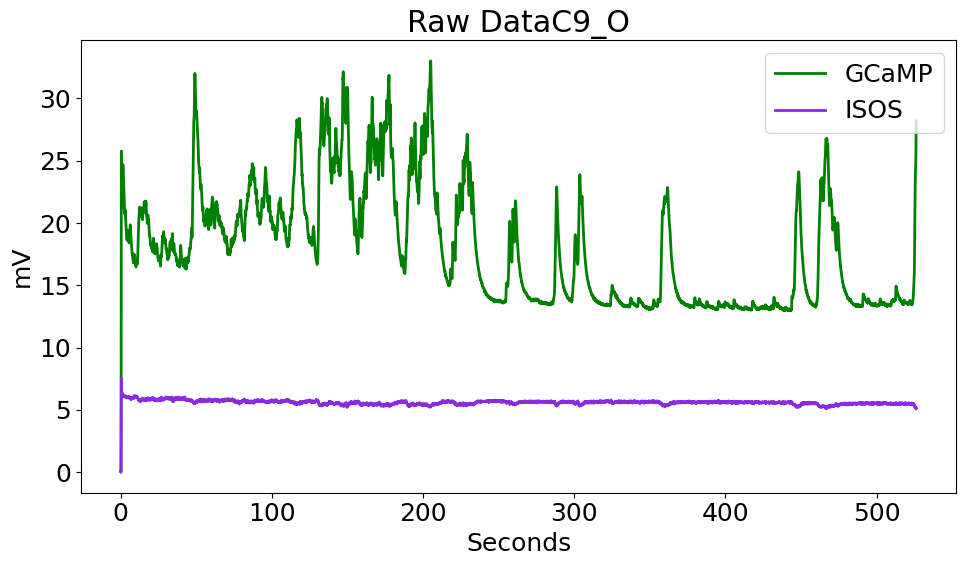

In [7]:
fig1 = plt.figure(figsize=(10, 6))
ax1 = fig1.add_subplot(111)

# Plotting the traces
p1, = ax1.plot(my_dict[tailfile_name]["Time"],my_dict[tailfile_name]["470"], linewidth=2, color='green', label='GCaMP')
p2, = ax1.plot(my_dict[tailfile_name]["Time"],my_dict[tailfile_name]["405"], linewidth=2, color='blueviolet', label='ISOS')

ax1.set_ylabel('mV')
ax1.set_xlabel('Seconds')
ax1.set_title('Raw Data' + tailfile_name)
ax1.legend(handles=[p1,p2],loc='upper right')
fig1.tight_layout()

In [8]:
first_ind = int(t_removal * frequency)
last_ind = int(t_end_removal * frequency)
print(first_ind, last_ind)

5086 5086


In [9]:
my_removed_dict = {}
new_dict = {}
my_dict_mice = my_dict[tailfile_name]
total_sample = len(my_dict_mice["405"])
for key, value in my_dict_mice.items():
    new_value = value[first_ind:total_sample-last_ind]
    new_dict[key] = new_value
my_dict_mice.update(new_dict)
my_removed_dict[tailfile_name] = my_dict_mice

In [10]:
my_fitted_dic = {}
# Fit 470 onto 405 
F405 = []
F470 = []
F470 = my_removed_dict[tailfile_name]["470"]
F405 = my_removed_dict[tailfile_name]["405"]
coefficients = np.polyfit(F405, F470, 1)
slope = coefficients[0]
intercept = coefficients[1]
fitted_F405 = [slope * x + intercept for x in F405]
corrected_470 = F470 - fitted_F405
my_fitted_dic[tailfile_name] = {"405": F405, "470": F470, "Time":my_removed_dict[tailfile_name]["Time"], "fitted_405": np.array(fitted_F405), "Corrected_470": corrected_470}

C:\Users\sabri\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3457: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


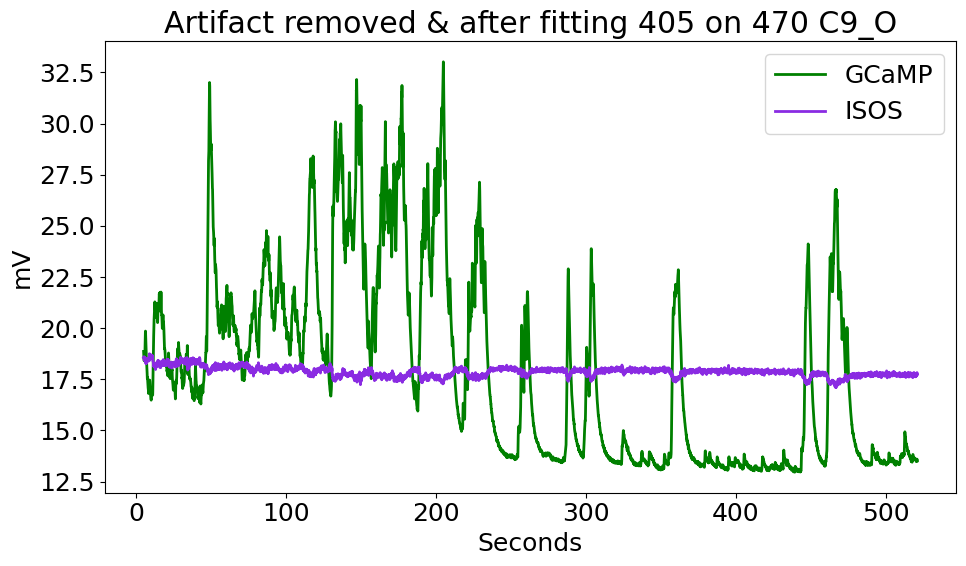

In [11]:
fig2 = plt.figure(figsize=(10, 6))
ax1 = fig2.add_subplot(111)

# Plotting the traces
p1, = ax1.plot(my_fitted_dic[tailfile_name]["Time"],my_fitted_dic[tailfile_name]["470"], linewidth=2, color='green', label='GCaMP')
p2, = ax1.plot(my_fitted_dic[tailfile_name]["Time"],my_fitted_dic[tailfile_name]["fitted_405"], linewidth=2, color='blueviolet', label='ISOS')

ax1.set_ylabel('mV')
ax1.set_xlabel('Seconds')
ax1.set_title('Artifact removed & after fitting 405 on 470 ' + tailfile_name)
ax1.legend(handles=[p1,p2],loc='upper right')
fig2.tight_layout()

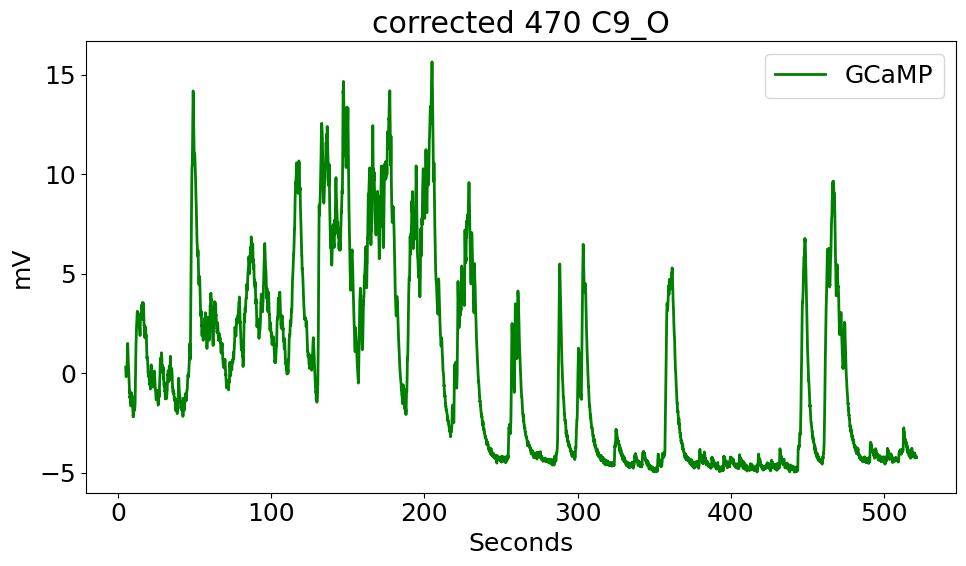

In [12]:
fig2 = plt.figure(figsize=(10, 6))
ax1 = fig2.add_subplot(111)

# Plotting the traces
p1, = ax1.plot(my_fitted_dic[tailfile_name]["Time"],my_fitted_dic[tailfile_name]["Corrected_470"], linewidth=2, color='green', label='GCaMP')
    
ax1.set_ylabel('mV')
ax1.set_xlabel('Seconds')
ax1.set_title('corrected 470 ' + tailfile_name)
ax1.legend(handles=[p1],loc='upper right')
fig2.tight_layout()

### calculating and plotting Zscore based on the whole trace

In [13]:
corrected_dff = my_fitted_dic[tailfile_name]["Corrected_470"]
time = my_dict[tailfile_name]["Time"]
averaged_time = time[::N]
my_fitted_dic[tailfile_name]["averaged_time"] = np.array(averaged_time)
mean_470 = statistics.mean(corrected_dff)
std_dev = statistics.stdev(corrected_dff)
Zscore = [ (x-mean_470)/std_dev for x in corrected_dff]
Zscore_averaged = [sum(Zscore[i:i+N])/N for i in range(0, len(Zscore), N)]
my_fitted_dic[tailfile_name]["Zscore"] = Zscore
my_fitted_dic[tailfile_name]["Zscore_averaged"] = Zscore_averaged
print(std_dev)

4.800091852082481


### Double check on how the behavior timepoint was sychronized with the ttl
fiberphotometry recording starts and then when ethovision starts it sends a ttl pulse to the fiberphotometry system and there is a pc0_on[0] in the signal
remove the t_removal because all the fiberphotometry data was cut in the very front of the analysis to exclude artifacts from movement into the arena. 

In [14]:
# behavior list from hand scoring in Ethovision
behavior_list =['intense struggle','moving','immobile']
#['rs','rs transition','tail suspend','groom','struggle','intense struggle']


In [15]:
y_scale = 2 #adjust according to data needs
y_shift = -5 
color_list = ['darkgray','saddlebrown','orchid','yellowgreen','lightsteelblue','purple','red','green']

In [16]:
behavior_dic = {}
pc0_on = time_point_dict[tailfile_name]["ep1"]
Log_path = fiberphotometry_path + "_processed" + ".xlsx"
df = pd.read_excel(Log_path)
df_duration = df.sort_values(by=['Behavior','Event'])
# synchronize fiberphotometry trace and behavior data 
df_duration["fiberphotometry_time"] = df_duration["Recording time"] + pc0_on[0]
df = df_duration
nested_dict = {}

for index, row in df.iterrows():
    behavior = row['Behavior']
    event = row['Event']
    fiber_time = row['fiberphotometry_time']

    if behavior not in nested_dict:
        nested_dict[behavior] = {}

    if event not in nested_dict[behavior]:
        nested_dict[behavior][event] = []

    nested_dict[behavior][event].append(fiber_time)

behavior_dic[tailfile_name] = nested_dict

### Plot Z score with behavior

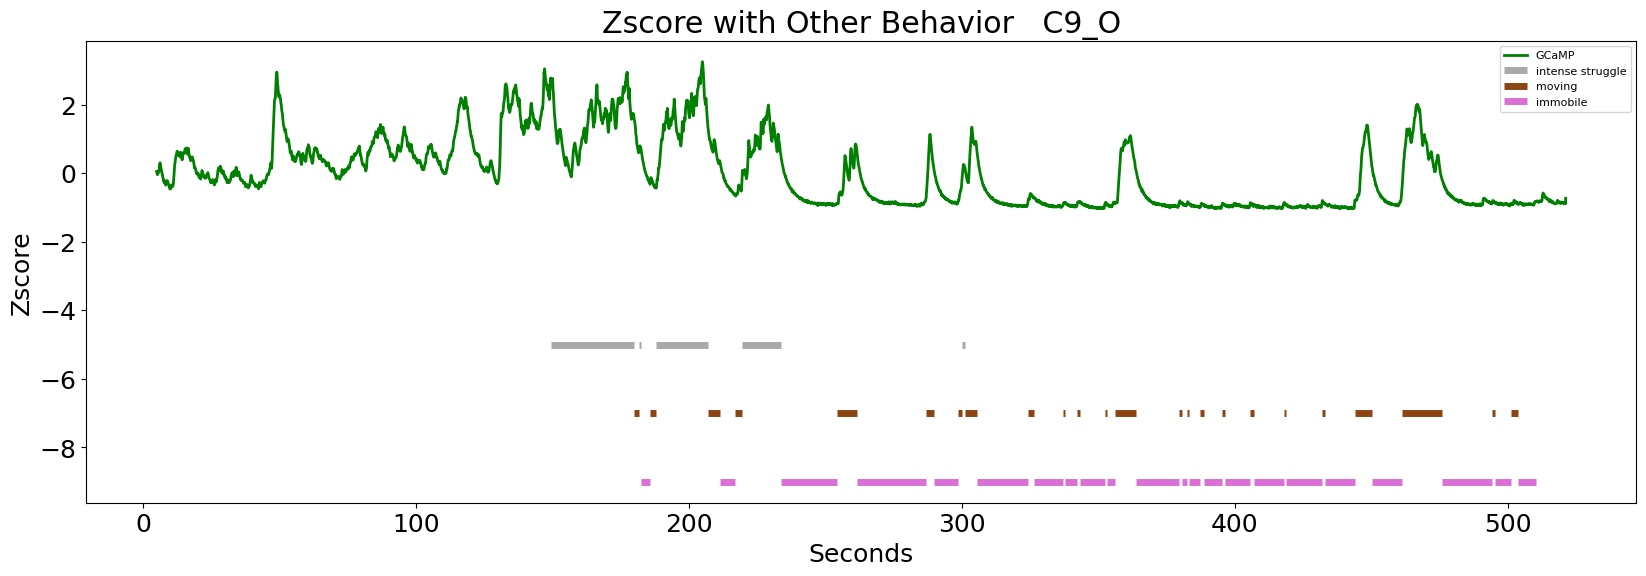

In [17]:
fig4 = plt.figure(figsize=(20,6))
ax3 = fig4.add_subplot(111)
downsampled_Zscore = my_fitted_dic[tailfile_name]["Zscore_averaged"]
averaged_time = my_fitted_dic[tailfile_name]["averaged_time"]
p1, = ax3.plot(averaged_time[:], downsampled_Zscore[:], linewidth=2, color='green', label='GCaMP')
#use line below if plotting velocity (or other continuous variable) in same graph as zscore and behavior
#p2, = ax3.plot(param_time, param_direction, label=interested_paramter)
for behavior_number in range (0,len(behavior_list)):
    behavior0 = df_duration[df_duration['Behavior'].str.contains(behavior_list[behavior_number])]
        # determine if it is point event or start/stop event 
    judgek = behavior0['Event'].str.contains('point event').values.tolist()
    #judgek = judgek[0]
    if judgek == True:
        behavior_start = behavior_dic[tailfile_name][behavior_list[behavior_number]]["point event"]
        lengs = len(behavior_start)
        for j in range (0,lengs):
            xmin_now = behavior_start[j]
            xmax_now = behavior_start[j]+2
            y_now = y_shift - behavior_number * y_scale 
                
            if j < (lengs-1):
                ax3.hlines(y= y_now , xmin=xmin_now, xmax=xmax_now, linewidth=5, color=color_list[behavior_number])
            else: 
                ax3.hlines(y= y_now , xmin=xmin_now, xmax=xmax_now, linewidth=5, color=color_list[behavior_number],label = behavior_list[behavior_number])
    else: 
        behavior_start = behavior_dic[tailfile_name][behavior_list[behavior_number]]["state start"]
        behavior_stop = behavior_dic[tailfile_name][behavior_list[behavior_number]]["state stop"]
        lengs = len(behavior_start)
        for j in range (0,lengs):
            xmin_now = behavior_start[j]
            xmax_now = behavior_stop[j]
            y_now = y_shift - behavior_number * y_scale 
            if j < (lengs-1):
                ax3.hlines(y= y_now , xmin=xmin_now, xmax=xmax_now, linewidth=5, color=color_list[behavior_number])
            else: 
                ax3.hlines(y= y_now , xmin=xmin_now, xmax=xmax_now, linewidth=5, color=color_list[behavior_number],label = behavior_list[behavior_number])
                ax3.set_ylabel(r'Zscore')
                ax3.set_xlabel('Seconds')
ax3.set_title('Zscore with Other Behavior   ' + tailfile_name)
ax3.legend(fontsize = 8) 

In [18]:
dff_start = -10
dff_end = 10

In [19]:
dff_start_timepoint = int(abs(dff_start)*frequency/N)
total_sample_contained = int ((dff_end-dff_start)*frequency/N)
time_stand = np.linspace(dff_start,dff_end,total_sample_contained)

In [20]:
Z_score_dic = {}
Zscore = my_fitted_dic[tailfile_name]["Zscore_averaged"]
my_dict_all_Zscore = {}

for behavior_number in range(0, len(behavior_list)):
    behavior0 = df_duration[df_duration['Behavior'].str.contains(behavior_list[behavior_number])]
    my_dict_every_behavior_Zscore = {}

    # determine if it is point event or start/stop event 
    judgek = behavior0['Event'].str.contains('point event').values.tolist()
    judgek = judgek[0]
    if judgek == True:
        behavior_start = behavior_dic[tailfile_name][behavior_list[behavior_number]]["point event"]
        video_corresponding_time = behavior_start #[time_point_dict[tailfile_name]["ep1"][0]+t_removal+x for x in behavior_start]
        string_list = [str(num) for num in video_corresponding_time]

        lengs = len(behavior_start)
        for j in range(0, lengs):
            xmin_now = behavior_start[j]
            timestamp_start = int((xmin_now - t_removal) * frequency / N) - dff_start_timepoint
            timestamp_stop = timestamp_start + total_sample_contained

            saved_Zscore = np.array(Zscore[timestamp_start:timestamp_stop])

            my_dict_every_behavior_Zscore[string_list[j]] = saved_Zscore

        my_dict_every_behavior_Zscore['time_point'] = time_stand


        my_dict_all_Zscore[behavior_list[behavior_number]] = my_dict_every_behavior_Zscore

    else: 
        behavior_start = behavior_dic[tailfile_name][behavior_list[behavior_number]]["state start"]
        behavior_stop = behavior_dic[tailfile_name][behavior_list[behavior_number]]["state stop"]
        video_corresponding_time = behavior_start # [time_point_dict[tailfile_list[k]]["ep1"][0]+t_removal+x for x in behavior_start]

        string_list = [str(num) for num in video_corresponding_time]

        lengs = len(behavior_start)
        for j in range(0, lengs):
            xmin_now = behavior_start[j]
            timestamp_start = int((xmin_now - t_removal) * frequency / N) - dff_start_timepoint
            timestamp_stop = timestamp_start + total_sample_contained

            saved_Zscore = np.array(Zscore[timestamp_start:timestamp_stop])


            my_dict_every_behavior_Zscore[string_list[j]] = saved_Zscore
            #print(parameter_start,parameter_stop)


        my_dict_every_behavior_Zscore['time_point'] = time_stand


        my_dict_all_Zscore[behavior_list[behavior_number]] = my_dict_every_behavior_Zscore
       

Z_score_dic[tailfile_name] = my_dict_all_Zscore


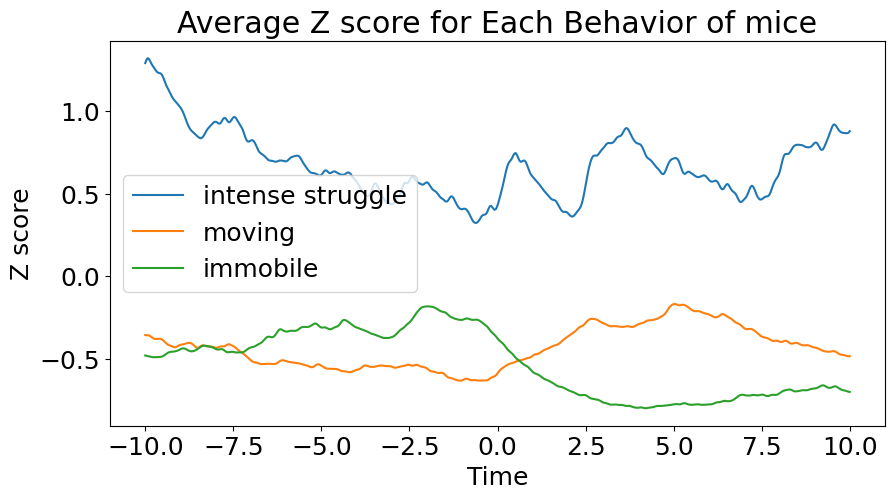

In [23]:
# Initialize an empty dictionary to hold the Z score values for each behavior
behavior_Zscore = {}


dict_Zscore_mice = Z_score_dic[tailfile_name]
    
# Iterate over all behaviors
for behavior, data in dict_Zscore_mice.items():
        
    # Exclude 'time_point' from the average calculation
    Zscore_values = [np.array(data[key]) for key in data if key != 'time_point']

    # If this behavior has not been encountered before, initialize it in the dictionary
    if behavior not in behavior_Zscore:
        behavior_Zscore[behavior] = []
        
    # Make all lists in Zscore_values the same length
    max_len = max(len(lst) for lst in Zscore_values)
    Zscore_values_equalized = [np.pad(lst, (0, max_len - len(lst)), 'constant', constant_values=np.nan) for lst in Zscore_values]

    # Append the equalized dF/F values for this behavior in this mouse to the list
    behavior_Zscore[behavior].extend(Zscore_values_equalized)

# Initialize an empty dictionary to hold the average dF/F values for each behavior
average_behavior_Zscore = {}

# Calculate the average dF/F across all mice for each behavior
for behavior, values in behavior_Zscore.items():
    max_len = max(len(lst) for lst in values)
    values_equalized = [np.pad(lst, (0, max_len - len(lst)), 'constant', constant_values=np.nan) for lst in values]
    average_behavior_Zscore[behavior] = np.nanmean(np.array(values_equalized), axis=0)

# Get the time_point array (assuming it's the same for all behaviors and mice)
time_point = list(dict_Zscore_mice.values())[0]['time_point']

# Plot the average dF/F for each behavior
plt.figure(figsize=(10, 5))
for behavior, Zscore in average_behavior_Zscore.items():
    plt.plot(time_point, Zscore, label=behavior)
plt.xlabel('Time')
plt.ylabel('Z score')
plt.title('Average Z score for Each Behavior of mice')
plt.legend()
plt.show()


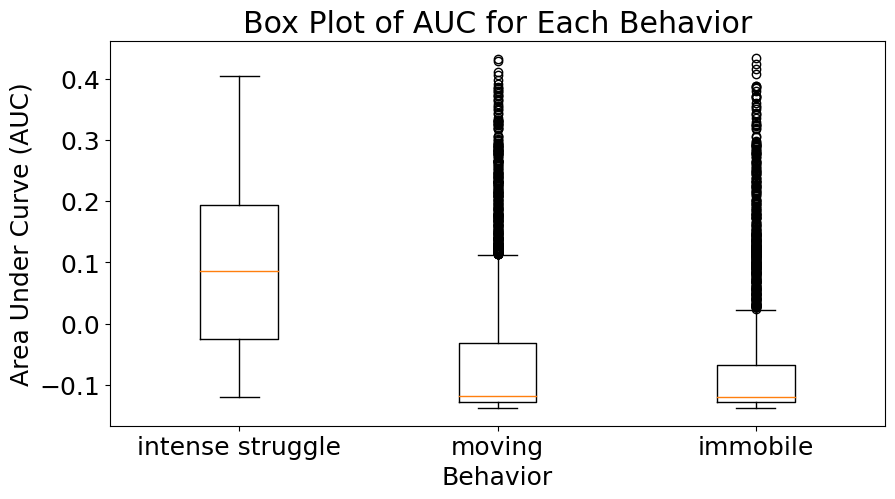

In [22]:
from sklearn.metrics import auc
from collections import defaultdict

# Initialize an empty dictionary to hold the AUC values for each behavior
behavior_AUC = defaultdict(list)

# Define the time interval (5 seconds)
time_interval = 5  # in seconds

# Iterate over all behaviors
for behavior, data in dict_Zscore_mice.items():
    time_points = data['time_point']
    # Exclude 'time_point' from the calculation
    for key, values in data.items():
        if key != 'time_point':
            # Split the values into chunks of 5 seconds
            chunks = [values[i:i+time_interval] for i in range(0, len(values), time_interval)]
            # Calculate AUC for each chunk
            for chunk in chunks:
                auc_value = auc(time_points[:len(chunk)], chunk)
                behavior_AUC[behavior].append(auc_value)

# Plot the box plot of AUC values for each behavior
plt.figure(figsize=(10, 5))
plt.boxplot(behavior_AUC.values(), labels=behavior_AUC.keys())
plt.xlabel('Behavior')
plt.ylabel('Area Under Curve (AUC)')
plt.title('Box Plot of AUC for Each Behavior')
plt.show()
